# Task : <br>1) Extract reviews of any product from ecommerce website like amazon<br>2) Perform emotion mining

## I scraped reviews of alexa echo dot 4 from amazon website. Then I performed Sentiment analysis on it. At last I performed Emotion mining by vectorizing the Reviews and predicting their values using Linear SVM.<br>Link for the same is <a href = "https://www.amazon.in/All-new-Echo-Dot-with-clock/product-reviews/B084J4MZQM/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=1">here</a>

In [490]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import nltk
from wordcloud import WordCloud

In [491]:
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy

# Applying Web Scraping

In [492]:
# import module
import requests
from bs4 import BeautifulSoup

HEADERS = ({'User-Agent':
			'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
			AppleWebKit/537.36 (KHTML, like Gecko) \
			Chrome/90.0.4430.212 Safari/537.36',
			'Accept-Language': 'en-US, en;q=0.5'})

# user define function
# Scrape the data
def getdata(url):
	r = requests.get(url, headers=HEADERS)
	return r.text


def html_code(url):

	# pass the url
	# into getdata function
	htmldata = getdata(url)
	soup = BeautifulSoup(htmldata, 'html.parser')

	# display html code
	return (soup)


#url = "https://www.amazon.in/All-new-Echo-Dot-with-clock/product-reviews/B084J4MZQM/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

#soup = html_code(url)
#print(soup)


### This is only HTML code or Raw data. Now since the core setup is done let us see how scraping for a specific requirement can be done.

# Scraping Review title

In [493]:
 title = []
 def get_review_title(soup):
    review_title = soup.find_all('a', {'data-hook': 'review-title'})
    for i in review_title:
        title.append(i.find('span').text.strip())
    #return title

# Scraping Reviews (body)

In [494]:
body = []
def get_review_body(soup):
    review_body = soup.find_all('span', {'data-hook': 'review-body'})
    for i in review_body:
        body.append(i.find('span').text.strip())
    #return body

# Scraping usernames

In [495]:
userlist = []
def get_username(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    for item in reviews:
        userlist.append(item.find('span').text.strip())

# Getting reviews from 10 review pages. Total of 100 reviews scraped.

In [496]:
# Getting reviews of 10 pages
for x in range(1,11):
    soup = html_code(f'https://www.amazon.in/All-new-Echo-Dot-with-clock/product-reviews/B084J4MZQM/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={x}')
    print(f'Getting page: {x}')
    get_username(soup)
    get_review_title(soup)
    #print(len(title))
    get_review_body(soup)

Getting page: 1
Getting page: 2
Getting page: 3
Getting page: 4
Getting page: 5
Getting page: 6
Getting page: 7
Getting page: 8
Getting page: 9
Getting page: 10


In [497]:
df = pd.DataFrame(userlist, columns= ['UserName'])
df['Review Title'] = title 
df['Review'] = body
df

,UserName,Review Title,Review
0,tango4567,Pre order booking received,Look: 👌👌👌👌White colour is seriously giving a ...
1,KV,Per order review,A bit over priced for the features it offers c...
2,Paresh,Works well,Understands almost everything in english and H...
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,Even boat stone speaker has better sound quali...
4,Sushil,RECOMMENDED. GO FOR IT.,My first smart speaker . :D beautiful lighting...
...,...,...,...
95,Pritish Kumar Rath,Improved Bass,Sound Quality is excellent.....very appealing ...
96,GD,My first Echo device,My first Echo device..yet to explore.. build q...
97,Random,Nice,It's nice. Got this in a combo offer with Wipr...
98,Shama bano,Worth of Money,This is my first echo dot and its a unique sma...


In [498]:
df.shape

(100, 3)

In [499]:
df.isnull().sum()

UserName        0
Review Title    0
Review          0
dtype: int64

# Data Cleaning

## Removing emojis

In [500]:
# text = u'This dog \U0001f602'
# print(text) # with emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def remove_emoji(text):
    text = emoji_pattern.sub(r'', text) # no emoji
    return text

In [501]:
df['Review'] = df['Review'].apply(remove_emoji)
df.head()

,UserName,Review Title,Review
0,tango4567,Pre order booking received,Look: White colour is seriously giving a feel...
1,KV,Per order review,A bit over priced for the features it offers c...
2,Paresh,Works well,Understands almost everything in english and H...
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,Even boat stone speaker has better sound quali...
4,Sushil,RECOMMENDED. GO FOR IT.,My first smart speaker . :D beautiful lighting...


## Removing stopwords and emoticons

In [502]:
stopwords_english =  stopwords.words('english')

emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3' , ':D', '.:D'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

In [503]:
lemmatizer = WordNetLemmatizer()

def clean_data(text):
    text_clean = []
    text_tokens = word_tokenize(text)
    #text_tokens = tokenizer.tokenize(text)    
    for word in text_tokens:
        if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = lemmatizer.lemmatize(word) # stemming word
            text_clean.append(stem_word)
    
    list_to_str = ' '.join([str(ele) for ele in text_clean])
    return list_to_str.lower()

In [504]:
df['Review'] = df['Review'].apply(clean_data)

In [505]:
df.head()

,UserName,Review Title,Review
0,tango4567,Pre order booking received,look white colour seriously giving feeling rec...
1,KV,Per order review,a bit priced feature offer currently specially...
2,Paresh,Works well,understands almost everything english hindi fo...
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,even boat stone speaker better sound quality c...
4,Sushil,RECOMMENDED. GO FOR IT.,my first smart speaker d beautiful lighting an...


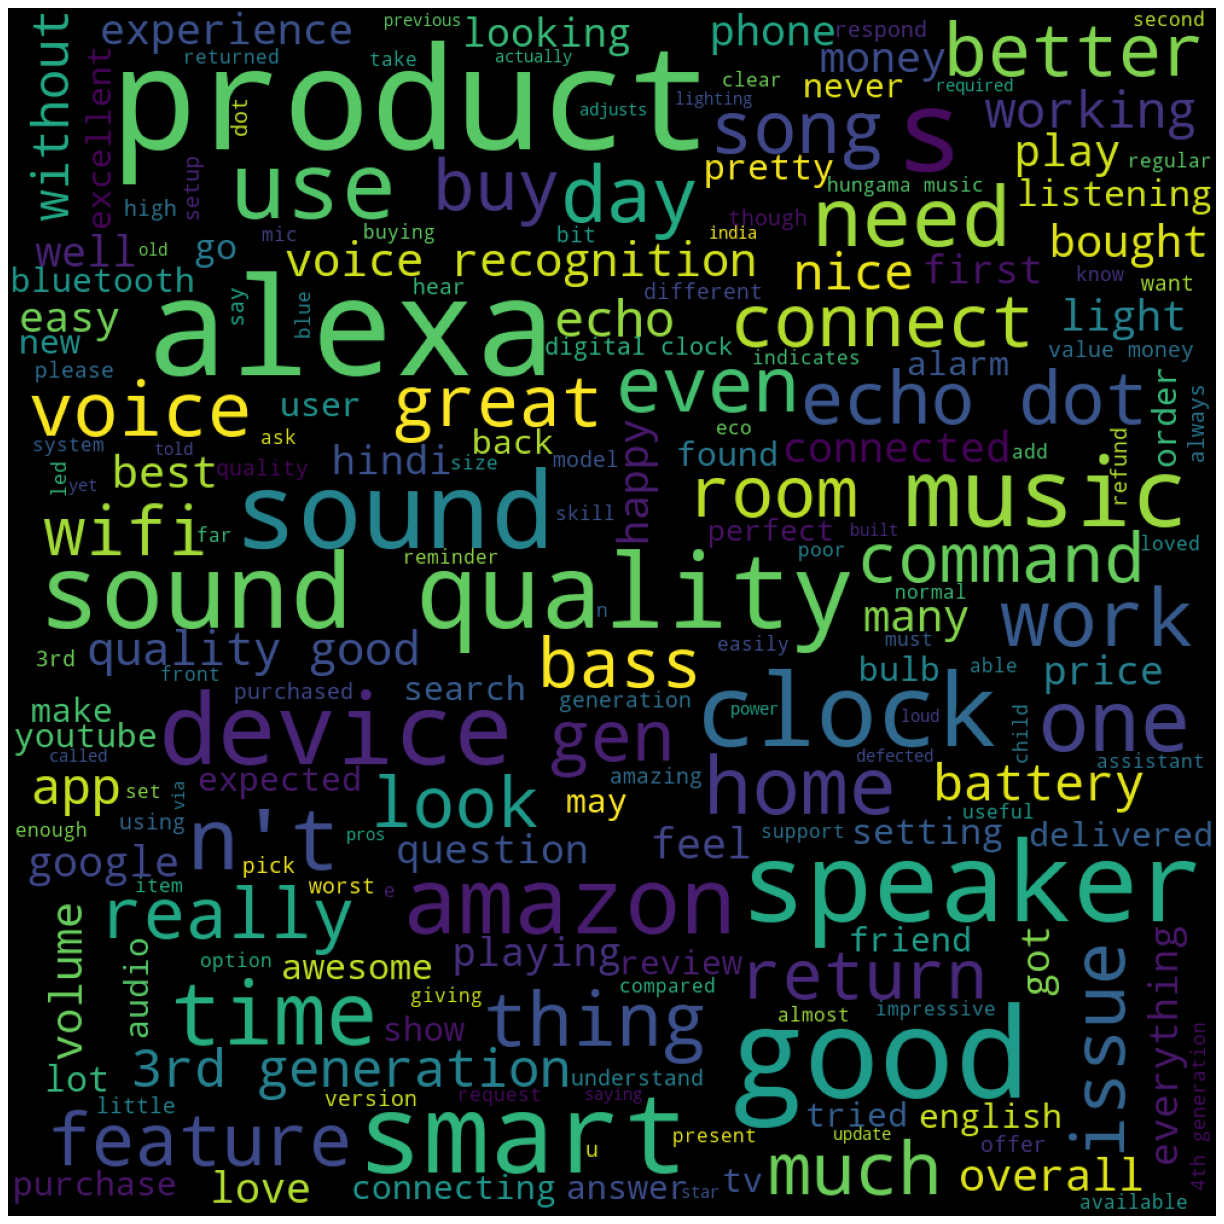

In [506]:
# Generating a wordcloud
allwords = " ".join([txt for txt in df["Review"]])
wordCloud = WordCloud(width = 1000, height = 1000, random_state = 42, max_font_size = 119).generate(allwords)
plt.figure(figsize=(20, 20), dpi=80)
plt.imshow(wordCloud)
plt.axis('off')
plt.show()

# Using vader_lexicon for sentiment analysis

In [507]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Harshpreet
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [508]:
sia = SentimentIntensityAnalyzer()

In [509]:
def get_vader_sentiment(review): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    sia = SentimentIntensityAnalyzer()
    # create TextBlob object of passed tweet text 
    analysis = sia.polarity_scores(review)
    # set sentiment 
    if analysis["compound"] > 0: 
        return 'positive'
    elif analysis["compound"] < 0: 
        return 'negative'
    else: 
        return 'neutral'

In [510]:
df["analysis"] = df["Review"].apply(get_vader_sentiment)
df.head(10)

,UserName,Review Title,Review,analysis
0,tango4567,Pre order booking received,look white colour seriously giving feeling rec...,positive
1,KV,Per order review,a bit priced feature offer currently specially...,positive
2,Paresh,Works well,understands almost everything english hindi fo...,positive
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,even boat stone speaker better sound quality c...,positive
4,Sushil,RECOMMENDED. GO FOR IT.,my first smart speaker d beautiful lighting an...,positive
5,Suresh S,Over-priced of echo dot with clock,product excellent size sound quality great ......,positive
6,YASH,Overall it's a nice product,overall 's nice product however product n't bu...,negative
7,Sachin Kamath,Mostly same as 3rd Gen Echo dot,i alexa 3rd generation without clock clock als...,positive
8,Vincent,Not working after only one week,i purchased product 10 day ago switching i kno...,negative
9,charan,go for 3rd generation best one,good 3rd generation sound good comparing 4th g...,positive


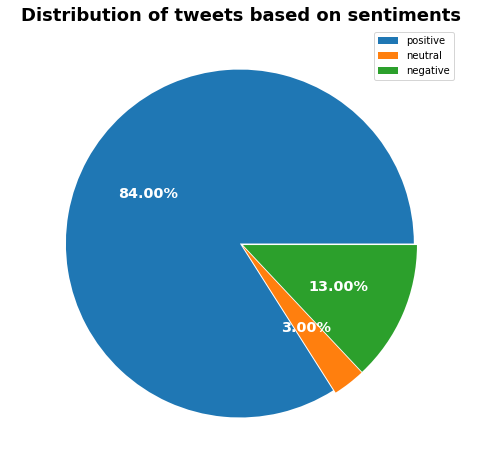

In [511]:
plt.figure(figsize = (10, 8))
twt_count = df[df['analysis'] == 'positive'].count().to_list()[0] , df[df['analysis'] == 'neutral'].count().to_list()[0] , df[df['analysis'] == 'negative'].count().to_list()[0]
plt.pie(twt_count, 
        labels = ['positive', 'neutral', 'negative'],
        autopct = '%.2f%%',
        explode=[0.01]*3, 
        textprops = {'size' : 'x-large',
                     'fontweight' : 'bold', 
                     'rotation' : '0',
                     'color' : 'w'})
plt.legend()
plt.title('Distribution of tweets based on sentiments', fontsize = 18, fontweight = 'bold')
plt.show()

### 84% reviews are positive , 13% negative and 3% neutral

## Getting compound scores for analysis of top positive and negative reviews

In [512]:
def get_compound_scores(text):
    return sia.polarity_scores(text)['compound']

In [513]:
df['score'] = df['Review'].apply(get_compound_scores)
df.head()

,UserName,Review Title,Review,analysis,score
0,tango4567,Pre order booking received,look white colour seriously giving feeling rec...,positive,0.8402
1,KV,Per order review,a bit priced feature offer currently specially...,positive,0.8020
2,Paresh,Works well,understands almost everything english hindi fo...,positive,0.4902
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,even boat stone speaker better sound quality c...,positive,0.7964
4,Sushil,RECOMMENDED. GO FOR IT.,my first smart speaker d beautiful lighting an...,positive,0.9020


In [514]:
# Top 10 positive Reviews
df_sort = df.sort_values(by = 'score' , ascending= False)
df_sort.head(10)

,UserName,Review Title,Review,analysis,score
16,Tarun Upadhyay,An intelligent Friend,`` a friend need friend indeed '' echo dot lik...,positive,0.9975
13,Keviv Ruhtam,It's Use is Limited By Your Imagination,i sure people writing bad review product may t...,positive,0.9965
14,Rakshith a Jakati,Must Buy ... Alexa 5 star,i working home past one half year handling wor...,positive,0.9937
72,neteena,Satisfied 😀,the product wroth money help child entertain t...,positive,0.9791
68,Niladri,Almost perfect product,everything perfect alexa work perfectly voice ...,positive,0.9726
41,Zak,A good one .,sound quality pretty impressive alexa ’ ai par...,positive,0.9607
28,Sri ram,Worthy every penny,to start good speaker sound ’ loud i give and ...,positive,0.9595
10,Yp,Superb I 💕 Alexa....,just day family started loving just buy become...,positive,0.9584
50,Shoueb,Great product again!,great product.like led clock feature.sound qua...,positive,0.9550
64,Kuldeep Sharma,Superb...,loved echo simple setup operate i pre-ordered ...,positive,0.9517


Text(0, 0.5, 'Score')

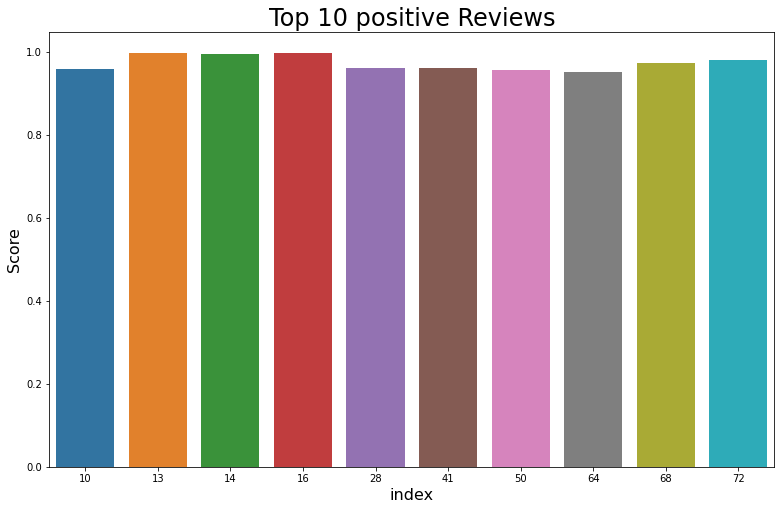

In [515]:
plt.figure(figsize= (13,8))
sns.barplot(x = df_sort.index[0:10] , y = df_sort.score[0:10])
plt.title('Top 10 positive Reviews' , fontsize = 24)
plt.xlabel('index', fontsize = 16)
plt.ylabel('Score', fontsize = 16)

## Printing top positive review

In [516]:
df.loc[df['score'].argmax()]['Review'] , df.loc[df['score'].argmax()]['score']

("`` a friend need friend indeed '' echo dot like true smart intelligent friend it 's upto training well tune it easily respond whenever say `` alexa '' .pros:1 easy smooth conversation.2 volume easily cover living room bedroom office i never set maximum 10 7 8 sufficient usually i set 6.3 while listening music base much balanced sound crystal clear it equipped amazon music hungama music apple music deezer iheartradio pandora siriusxm spotify tidal tunein vevo.4 as far intelligence general knowledge concern bang it give exact answer related gk question you also add question answer 'my question section i.e alexa please tell best youtube answers name 5 it connects diligently different smart device like smart tv ac smart switch smart bulbs etc no issue i found i connected smart device home.6 it 's led light glow indicates 's status quite well blue led indicates working fine yellow indicates setup mode red indicates device need troubleshoot.7 it 's one best friend home so enjoy it 's compa

## Top 10 negative reviews

Text(0, 0.5, 'Score')

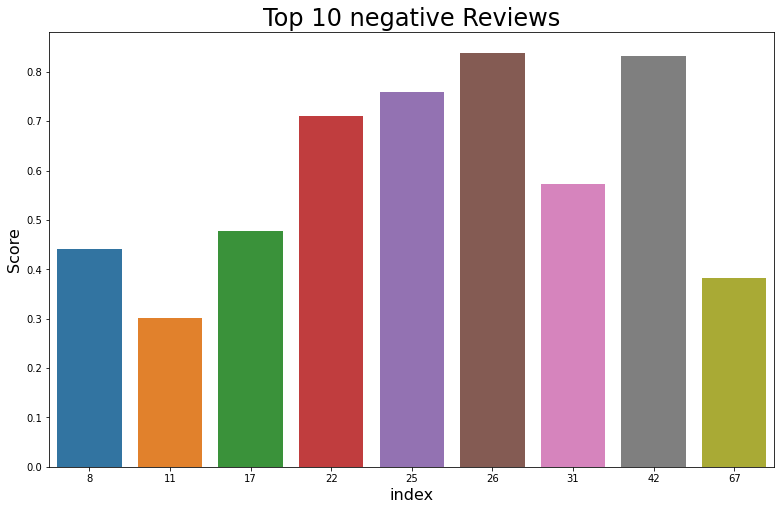

In [517]:
plt.figure(figsize= (13,8))
sns.barplot(x = df_sort.index[:-10:-1] , y = abs(df_sort.score[:-10:-1]))
plt.title('Top 10 negative Reviews' , fontsize = 24)
plt.xlabel('index', fontsize = 16)
plt.ylabel('Score', fontsize = 16)

## Printing top negative review

In [518]:
df.loc[26]['Review'] , df.loc[26]['score']

('this alexa 4th generation eco dot clock without battery backup this useless need plugin power source always otherwise work battery back up.for me it is useless product as it can not work without flexibility to use this product as there is no battery charging facilities.when i purchased i was not informed at amazon e-commerce portal which i came to know yesterday 17 june 2021.i request amazon to return this and refund.prof. dr manoj kumar sharmacustomer',
 -0.8389)

## Generating wordclouds for positive and negative words used in reviews

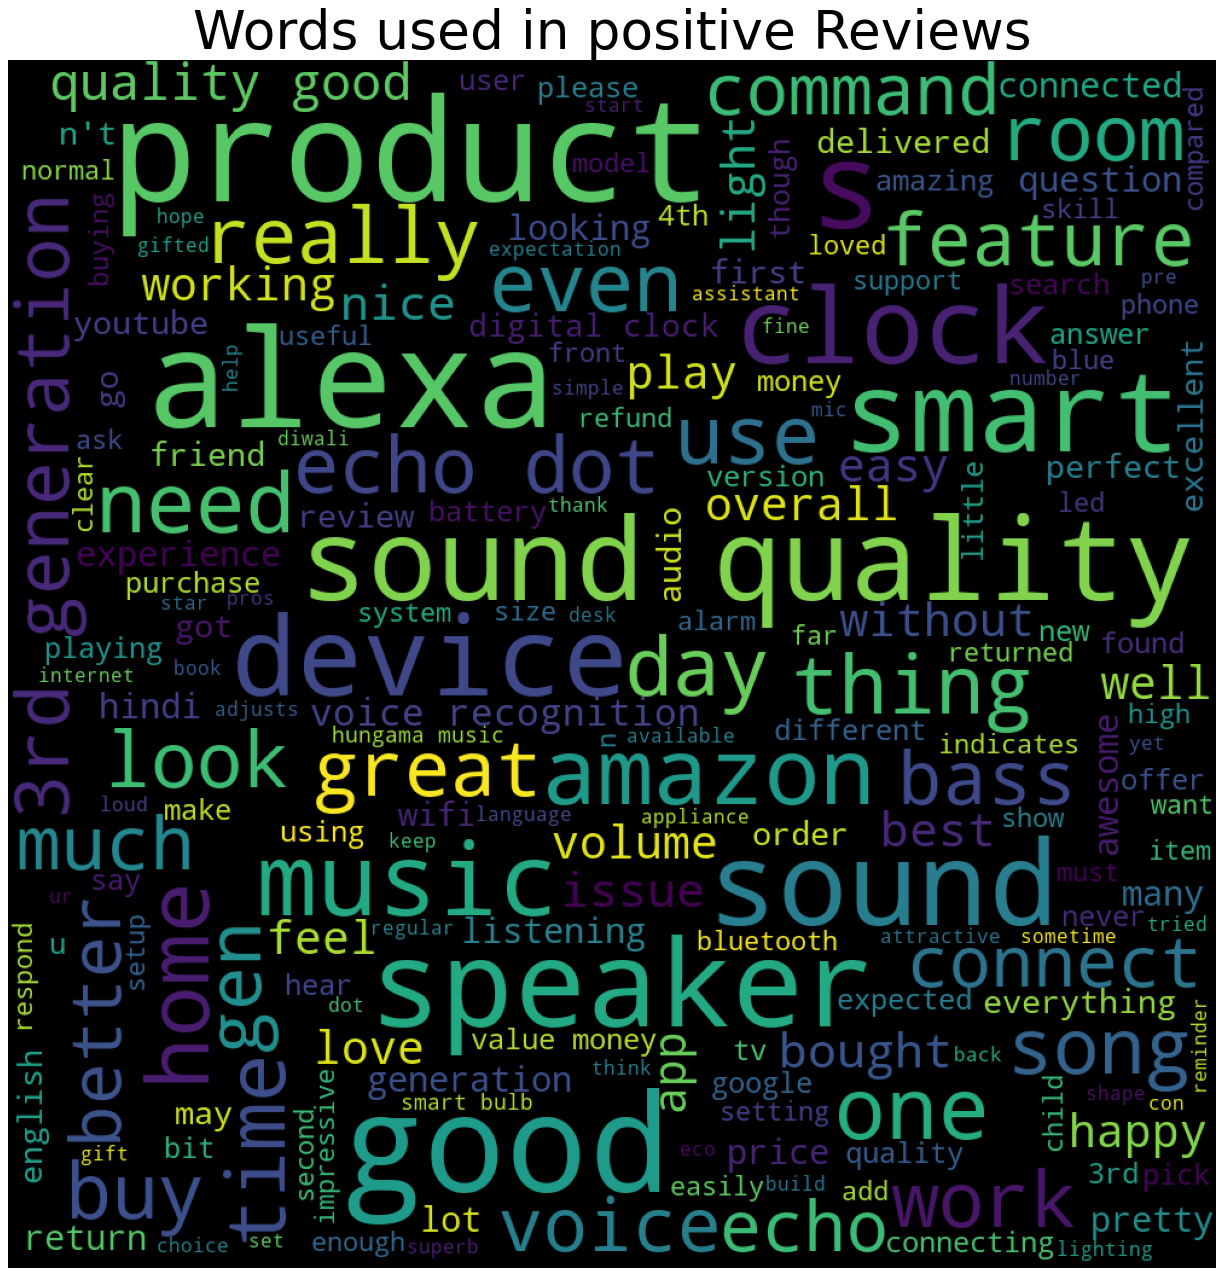

In [519]:
# Generating a wordcloud
allwords = " ".join([txt for txt in df_sort[df_sort['score'] > 0]['Review']])
wordCloud = WordCloud(width = 1000, height = 1000, random_state = 42, max_font_size = 119).generate(allwords)
plt.figure(figsize=(20, 20), dpi=80)
plt.imshow(wordCloud)
plt.axis('off')
plt.title('Words used in positive Reviews' , fontsize = 48)
plt.show()

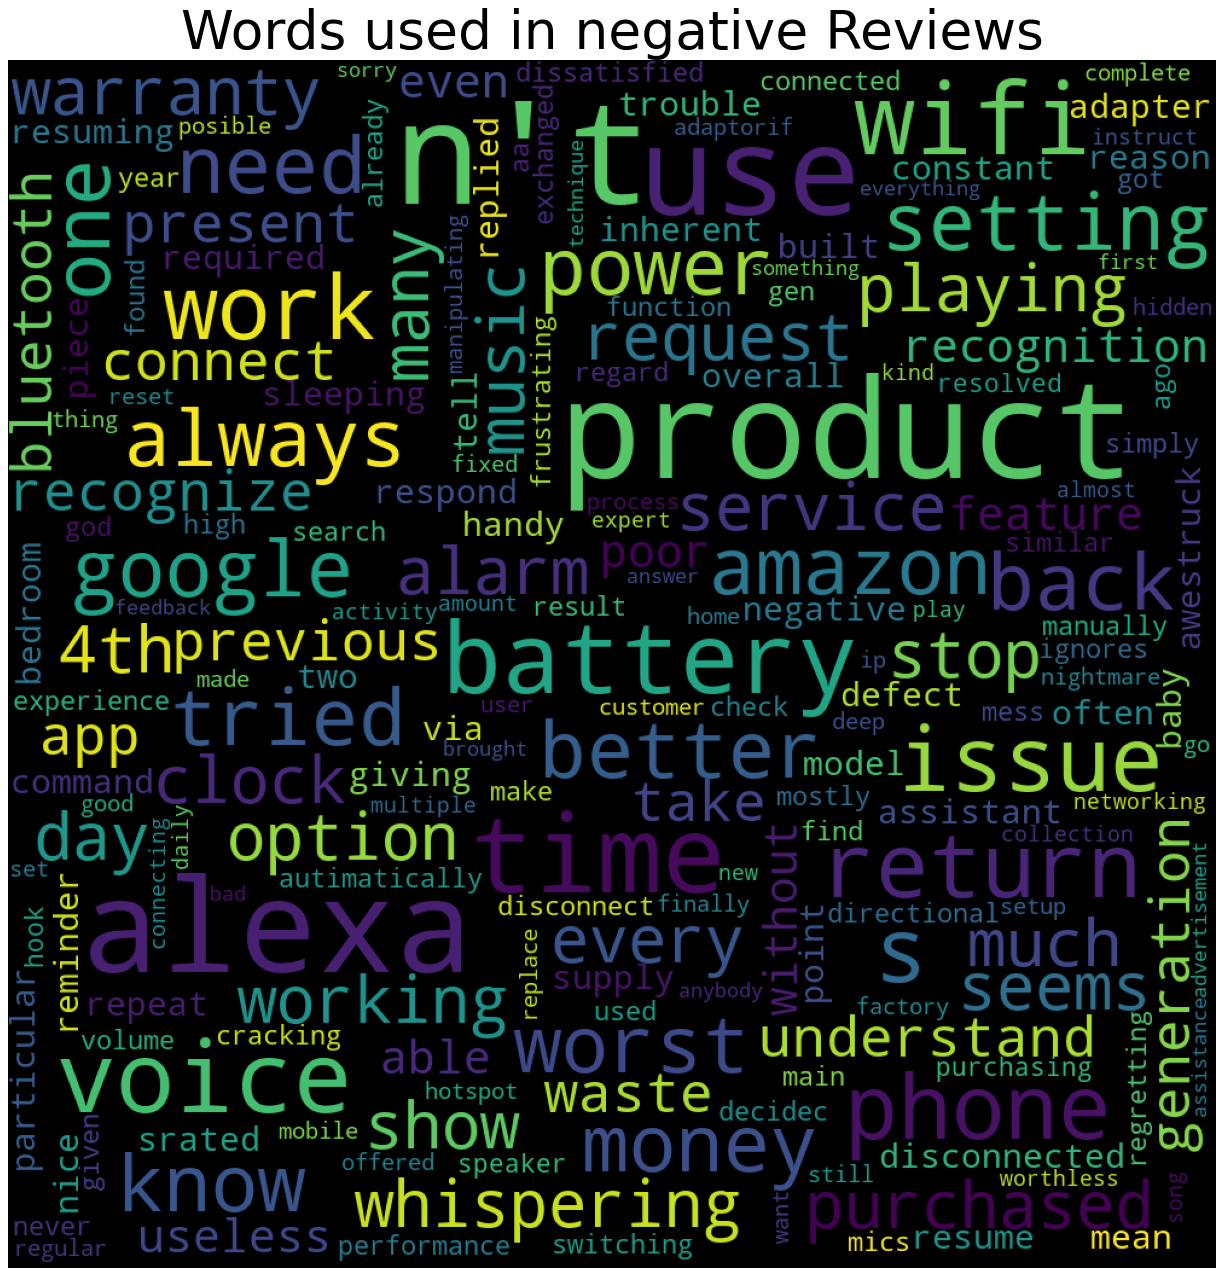

In [520]:
allwords = " ".join([txt for txt in df_sort[df_sort['score'] < 0]['Review']])
wordCloud = WordCloud(width = 1000, height = 1000, random_state = 42, max_font_size = 119).generate(allwords)
plt.figure(figsize=(20, 20), dpi=80)
plt.imshow(wordCloud)
plt.axis('off')
plt.title('Words used in negative Reviews' , fontsize = 48)
plt.show()

# Emotion Mining

## Getting affinity scores for english words

In [521]:
afinn = pd.read_csv('data/Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [522]:
afinn.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [523]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [524]:
nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = affinity_scores
def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [525]:
df['Sentiment_value'] = df['Review'].apply(calculate_sentiment)

In [526]:
# Calculating no. of words in each review
df['word_count'] = df['Review'].str.split().apply(len)
df.head(10)

,UserName,Review Title,Review,analysis,score,Sentiment_value,word_count
0,tango4567,Pre order booking received,look white colour seriously giving feeling rec...,positive,0.8402,4,16
1,KV,Per order review,a bit priced feature offer currently specially...,positive,0.8020,5,43
2,Paresh,Works well,understands almost everything english hindi fo...,positive,0.4902,-1,76
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,even boat stone speaker better sound quality c...,positive,0.7964,-4,87
4,Sushil,RECOMMENDED. GO FOR IT.,my first smart speaker d beautiful lighting an...,positive,0.9020,8,37
5,Suresh S,Over-priced of echo dot with clock,product excellent size sound quality great ......,positive,0.8316,6,29
6,YASH,Overall it's a nice product,overall 's nice product however product n't bu...,negative,-0.2263,1,18
7,Sachin Kamath,Mostly same as 3rd Gen Echo dot,i alexa 3rd generation without clock clock als...,positive,0.7717,2,126
8,Vincent,Not working after only one week,i purchased product 10 day ago switching i kno...,negative,-0.4404,-2,28
9,charan,go for 3rd generation best one,good 3rd generation sound good comparing 4th g...,positive,0.5859,9,26


### It is interesting to note that for positive analysis given by vader_lexicon , some Sentiment values given by spacy are negative and vice versa.

In [527]:
a = pd.Series(df[df['Sentiment_value'] > 0]['analysis'] == 'negative')

In [528]:
a.value_counts()

False    78
True      2
Name: analysis, dtype: int64

### It implies that there are 2 cases where Sentiment_value = positive and analysis = negative 

In [529]:
b = pd.Series(df[df['Sentiment_value'] < 0]['analysis'] == 'positive')
b.value_counts()

False    10
True      4
Name: analysis, dtype: int64

### It implies that there are 4 cases where Sentiment_value = negative and analysis = positive

<AxesSubplot:xlabel='Sentiment_value', ylabel='Density'>

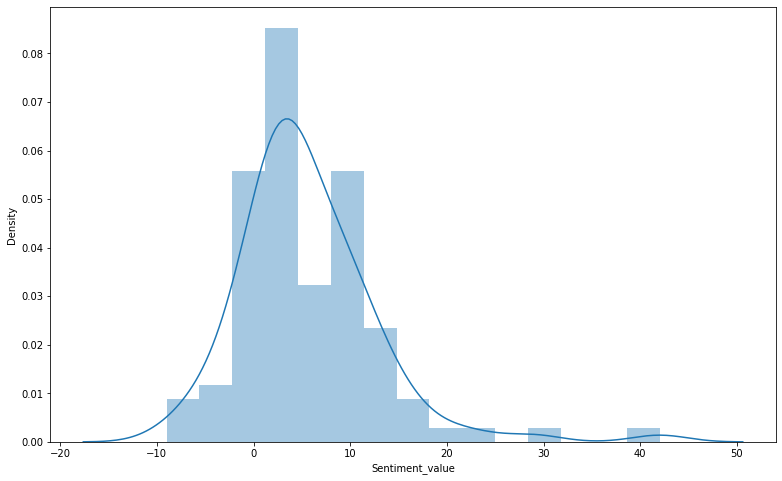

In [530]:
plt.figure(figsize= (13,8))
sns.distplot(df['Sentiment_value'])

# Model building

In [531]:
from sklearn.model_selection import train_test_split

In [532]:
def get_value(i):
    if i>0:
        return 1
    elif i==0:
        return 0
    else:
        return -1

In [533]:
df['target'] = df['Sentiment_value'].apply(get_value)

In [534]:
df

,UserName,Review Title,Review,analysis,score,Sentiment_value,word_count,target
0,tango4567,Pre order booking received,look white colour seriously giving feeling rec...,positive,0.8402,4,16,1
1,KV,Per order review,a bit priced feature offer currently specially...,positive,0.8020,5,43,1
2,Paresh,Works well,understands almost everything english hindi fo...,positive,0.4902,-1,76,-1
3,Dashan j.,Zero value of money |Low bass| poor sound qual...,even boat stone speaker better sound quality c...,positive,0.7964,-4,87,-1
4,Sushil,RECOMMENDED. GO FOR IT.,my first smart speaker d beautiful lighting an...,positive,0.9020,8,37,1
...,...,...,...,...,...,...,...,...
95,Pritish Kumar Rath,Improved Bass,sound quality excellent ..... appealing aesthe...,positive,0.5719,3,8,1
96,GD,My first Echo device,my first echo device .. yet explore .. build q...,positive,0.7650,4,43,1
97,Random,Nice,it 's nice got combo offer wipro smart bulb bo...,positive,0.9260,10,17,1
98,Shama bano,Worth of Money,this first echo dot unique smart speaker kid i...,positive,0.6908,3,13,1


In [535]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.pipeline import Pipeline

In [546]:
vectorizer = CountVectorizer()
svc = LinearSVC()

In [547]:
vectorizer2 = CountVectorizer()
x = vectorizer.fit_transform(df['Review'])
x.toarray()
y = df['target']

In [548]:
x_train , x_test , y_train , y_test = train_test_split(x, y , test_size= 0.20 , random_state= 42)

In [549]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((80, 1168), (20, 1168), (80,), (20,))

In [550]:
svc.fit(x_train , y_train)
y_pred = svc.predict(x_test)
pd.Series(y_pred).value_counts()

 1    18
-1     2
dtype: int64

In [551]:
from sklearn.metrics import confusion_matrix , accuracy_score

In [552]:
confusion_matrix(y_pred , y_test)

array([[ 0,  1,  1],
       [ 0,  0,  0],
       [ 1,  0, 17]], dtype=int64)

In [553]:
accuracy_score(y_pred , y_test)

0.85

### We have got 85% accuracy on predictions